### Import required packages and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from scipy.stats import skew, kurtosis
from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.holiday import USFederalHolidayCalendar
import pandas_datareader.data as web
import warnings
import functions_part_II
warnings.filterwarnings("ignore")
from functions_part_II import delta_hedging, calendar_to_business_days, create_straddles, process_straddles, dp_hedging_collect_training_data, train_random_forest_model, apply_hedging_model, get_feature_importance, plot_feature_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
import importlib
importlib.reload(functions_part_II)

<module 'functions_part_II' from 'c:\\Users\\benj0\\OneDrive - HEC Montréal\\Desktop\\Straddle_hedging_project\\functions_part_II.py'>

### Initialize important dates

In [3]:
start_date = '2007-01-01'
end_date = '2023-09-30'

training_start_date = '2007-01-01'
training_end_date = '2015-12-31'
test_start_date = '2016-01-01'
test_end_date = '2023-08-31'

### Fetch and Process S&P prices data

In [4]:
sp = yf.download('^SPX')

sp.index = pd.to_datetime(sp.index)

# Filter the DataFrame
filtered_sp = sp.loc[start_date:end_date]

# Remove the ticker level from the multi index
filtered_sp.columns = filtered_sp.columns.droplevel(1)
filtered_sp = pd.DataFrame(filtered_sp['Close'], index=filtered_sp.index)
filtered_sp.index = pd.to_datetime(filtered_sp.index).tz_localize(None)

[*********************100%***********************]  1 of 1 completed


### Fetch and Process Fama French Risk free rate data

In [5]:
# Fetch the Fama-French 3-factor data
ff_data = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start_date, end_date)

# Convert period index to datetime
rf_data = ff_data[0]  # Extract the first dataframe (RF)
rf_data.index = rf_data.index.to_timestamp()  

# Select the RF column (risk-free rate)
risk_free_rate = pd.DataFrame(rf_data['RF'])

# Resample to daily frequency, forward-fill missing values (public holidays), and annualize the risk free rate
risk_free_rate = risk_free_rate.resample('D').ffill()
risk_free_rate = risk_free_rate * 12 / 100

### Reindex data to forward fill prices and risk free for public holidays

In [6]:
market_df = filtered_sp.merge(risk_free_rate, left_index=True, right_index=True)

# Create a new business day index
new_index = pd.bdate_range(start=start_date, end=end_date)

# Create a new DataFrame with the business day index
real_market_df = pd.DataFrame(index=new_index)

# Merge the existing market_df with the new DataFrame
real_market_df = real_market_df.merge(market_df, left_index=True, right_index=True, how='left')

# Forward fill the missing values
real_market_df.ffill(inplace=True)

# Rename the index to 'Date' if necessary
real_market_df.index.name = 'Date'

# Display the updated DataFrame
real_market_df

,Close,RF
Date,,
2007-01-01,NaN,NaN
2007-01-02,NaN,NaN
2007-01-03,1416.599976,0.0528
2007-01-04,1418.339966,0.0528
2007-01-05,1409.709961,0.0528
...,...,...
2023-09-25,4515.770020,0.0516
2023-09-26,4515.770020,0.0516
2023-09-27,4515.770020,0.0516


### Read Option data

In [7]:
# Read data from CSV
data = pd.read_csv('filtered_data_cleaned.csv')
data.set_index('Date', inplace=True)

In [8]:
best_features = pd.read_csv('best_features.csv')
best_features

,Date,RV_1D,RET_1D,RET_1M,IV_Butterfly,IV_TERM_3M_1M,CRUDE_OIL_YoY
0,2005-01-03,0.148802,-0.008119,0.009159,0.00380,0.0116,0.246892
1,2005-01-04,0.119283,-0.011671,-0.001848,0.00410,0.0116,0.302967
2,2005-01-05,0.121519,-0.003628,0.005658,0.00320,0.0098,0.290601
3,2005-01-06,0.111861,0.003506,0.004295,0.00385,0.0095,0.340789
4,2005-01-07,0.129115,-0.001431,-0.002565,0.00370,0.0097,0.324104
...,...,...,...,...,...,...,...
4922,2024-07-25,0.214469,-0.005143,-0.014363,0.00155,-0.0037,-0.022600
4923,2024-07-26,0.175739,0.011090,-0.004335,0.00085,0.0007,-0.042442
4924,2024-07-29,0.131191,0.000813,0.000560,0.00000,-0.0002,-0.073227
4925,2024-07-30,0.202037,-0.004960,-0.007059,0.00030,-0.0022,-0.081603


In [9]:
data = data.merge(best_features, left_index=True, right_on='Date', how='inner')
data.set_index('Date', inplace=True)


In [10]:
data

,exdate,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,delta,gamma,vega,...,contract_size,D to Expiration,Close,Moneyness,RV_1D,RET_1D,RET_1M,IV_Butterfly,IV_TERM_3M_1M,CRUDE_OIL_YoY
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,2005-01-22,C,1175.0,33.7,35.7,135,0.159263,0.756581,0.007369,83.62589,...,100,19,1202.079956,0.977472,0.148802,-0.008119,0.009159,0.00380,0.0116,0.246892
2005-01-03,2005-01-22,C,1185.0,25.6,27.6,29,0.148154,0.686993,0.008958,94.57140,...,100,19,1202.079956,0.985791,0.148802,-0.008119,0.009159,0.00380,0.0116,0.246892
2005-01-03,2005-01-22,C,1190.0,21.7,23.7,3,0.141677,0.645919,0.009835,99.29028,...,100,19,1202.079956,0.989951,0.148802,-0.008119,0.009159,0.00380,0.0116,0.246892
2005-01-03,2005-01-22,C,1195.0,18.4,20.0,40,0.137227,0.597883,0.010561,103.27420,...,100,19,1202.079956,0.994110,0.148802,-0.008119,0.009159,0.00380,0.0116,0.246892
2005-01-03,2005-01-22,P,1175.0,4.3,4.5,10162,0.136510,-0.210187,0.007913,76.97430,...,100,19,1202.079956,0.977472,0.148802,-0.008119,0.009159,0.00380,0.0116,0.246892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,2023-09-29,P,4435.0,28.8,29.1,21,0.128259,-0.281094,0.002070,428.51640,...,100,29,4507.660156,0.983881,0.086130,-0.001597,-0.001270,0.00185,0.0159,-0.034407
2023-08-31,2023-10-02,C,4515.0,65.4,65.9,0,0.111276,0.540238,0.002672,529.71470,...,100,32,4507.660156,1.001628,0.086130,-0.001597,-0.001270,0.00185,0.0159,-0.034407
2023-08-31,2023-10-02,P,4515.0,53.5,53.9,12,0.112415,-0.459972,0.002645,529.75150,...,100,32,4507.660156,1.001628,0.086130,-0.001597,-0.001270,0.00185,0.0159,-0.034407


### Define training and testing data

In [11]:
data_train = data[training_start_date:training_end_date]
option_df_train = data_train
data_train.index = pd.to_datetime(data_train.index)

data_test = data[test_start_date:test_end_date]
option_df_test = data_test
data_test.index = pd.to_datetime(data_test.index)

### Compute MidPrice and convert calendar days to business days

In [12]:
# Get midprice for all data
data_train['Midprice'] = (data_train['best_bid'] + data_train['best_offer']) / 2
data_test['Midprice'] = (data_test['best_bid'] + data_test['best_offer']) / 2

# convert calendar to business days
option_df_train['Business_Days_to_Expiration'] = option_df_train.apply(lambda row: calendar_to_business_days(row.name, row['exdate'], row['D to Expiration']), axis=1)
option_df_test['Business_Days_to_Expiration'] = option_df_test.apply(lambda row: calendar_to_business_days(row.name, row['exdate'], row['D to Expiration']), axis=1)

### Keep only options with 1 month or more to maturity

In [13]:
data_1m_train = data_train[data_train['Business_Days_to_Expiration'] >= 22]
data_1m_train.index = pd.to_datetime(data_1m_train.index)

data_1m_test = data_test[data_test['Business_Days_to_Expiration'] >= 22]
data_1m_test.index = pd.to_datetime(data_1m_test.index)

### Create Straddles for each dates

In [14]:
# Group the data by date, strike price, and expiration date
groups_train = data_1m_train.groupby(['Date', 'strike_price', 'Business_Days_to_Expiration'])
groups_test = data_1m_test.groupby(['Date', 'strike_price', 'Business_Days_to_Expiration'])

straddles_df_train = create_straddles(groups_train)
straddles_df_test = create_straddles(groups_test)

### If the straddle starts later than 10th of the month, remove it to comply with the requirement that we choose a straddle at the "beginning" of the month

In [15]:
for dates in straddles_df_train.index:
    if dates.day > 10:
        straddles_df_train.drop(dates, inplace=True, errors='ignore')

for dates in straddles_df_test.index:
    if dates.day > 10:
        straddles_df_test.drop(dates, inplace=True, errors='ignore')

### For each month, choose only one straddle, the one with a moneyness closest to 1

In [16]:
first_straddles_monthly_train = process_straddles(straddles_df_train)
first_straddles_monthly_test = process_straddles(straddles_df_test)

### Apply delta hedging to train and test data, with and without transaction costs

In [17]:
# No transaction cost, training P&L
profit_no_cost_train = delta_hedging(first_straddles_monthly_train, option_df_train, real_market_df, transaction_cost=0)
profit_no_cost_train.set_index('Date', inplace=True)
profit_no_cost_train['Cumulative P&L'] = profit_no_cost_train['P&L'].cumsum()

In [18]:
# Transaction cost, testing P&L
profit_cost_train = delta_hedging(first_straddles_monthly_train, option_df_train, real_market_df, transaction_cost=0.005)
profit_cost_train.set_index('Date', inplace=True)
profit_cost_train['Cumulative P&L'] = profit_cost_train['P&L'].cumsum()

In [19]:
# No transaction cost, training P&L
profit_no_cost_test = delta_hedging(first_straddles_monthly_test, option_df_test, real_market_df, transaction_cost=0)
profit_no_cost_test.set_index('Date', inplace=True)
profit_no_cost_test['Cumulative P&L'] = profit_no_cost_test['P&L'].cumsum()
profit_no_cost_test

,Initial Value,Final Cash Value,Payoff,Hedging Error,P&L,Cumulative P&L
Date,,,,,,
2016-01-06,83.50,83.510379,109.949951,699.050987,-26.439572,-26.439572
2016-02-04,95.00,95.023291,107.189941,148.027371,-12.166650,-38.606222
2016-03-10,79.65,79.665468,90.729980,122.423439,-11.064513,-49.670735
2016-04-05,72.95,72.959369,1.609985,5090.734575,71.349384,21.678649
2016-05-04,66.45,66.457352,49.129883,300.241196,17.327469,39.006118
...,...,...,...,...,...,...
2023-04-06,173.75,174.563819,19.080078,24175.193697,155.483741,283.953363
2023-05-08,141.80,142.450138,158.859863,269.279072,-16.409725,267.543638
2023-06-08,108.60,109.156772,114.529785,28.869272,-5.373013,262.170625


In [20]:
# Transaction cost, testing P&L
profit_cost_test = delta_hedging(first_straddles_monthly_test, option_df_test, real_market_df, transaction_cost=0.005)
profit_cost_test.set_index('Date', inplace=True)
profit_cost_test['Cumulative P&L'] = profit_cost_test['P&L'].cumsum()
print(f"Tracking Error: {profit_cost_test['P&L'].std()}")
profit_cost_test

Tracking Error: 99.62706000252963


,Initial Value,Final Cash Value,Payoff,Hedging Error,P&L,Cumulative P&L
Date,,,,,,
2016-01-06,83.50,83.468310,109.949951,701.277338,-26.481642,-26.481642
2016-02-04,95.00,94.899783,107.189941,151.048004,-12.290159,-38.771800
2016-03-10,79.65,79.422018,90.729980,127.870026,-11.307963,-50.079763
2016-04-05,72.95,72.583347,1.609985,5037.218067,70.973362,20.893598
2016-05-04,66.45,66.202729,49.129883,291.482079,17.072846,37.966445
...,...,...,...,...,...,...
2023-04-06,173.75,173.010255,19.080078,23694.499253,153.930177,249.283946
2023-05-08,141.80,141.013588,158.859863,318.489558,-17.846276,231.437670
2023-06-08,108.60,106.853616,114.529785,58.923575,-7.676169,223.761501


### Plot the cumulative P&L of the test data

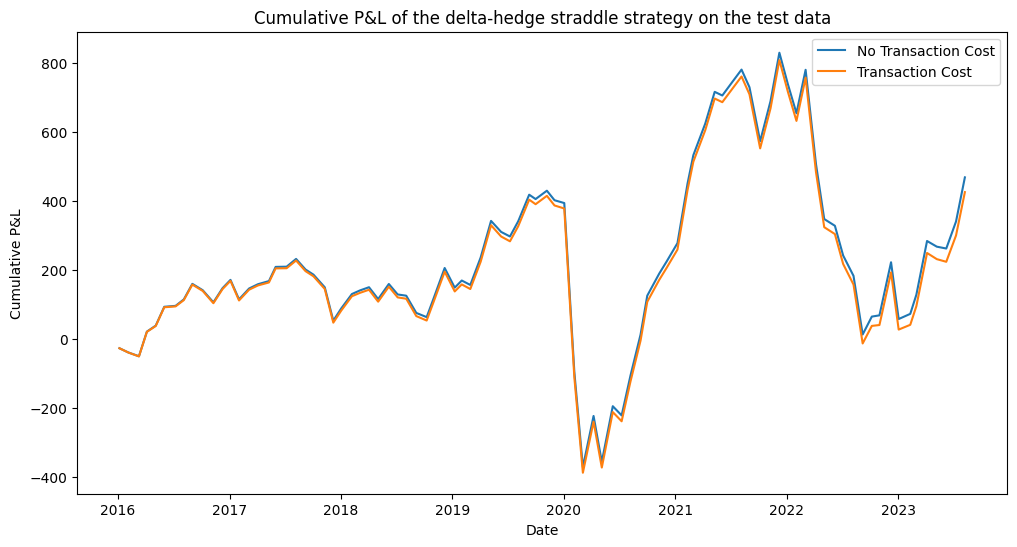

In [21]:
# Plot the cumulative P&L of the test data
plt.figure(figsize=(12, 6))
plt.plot(profit_no_cost_test['Cumulative P&L'], label='No Transaction Cost')
plt.plot(profit_cost_test['Cumulative P&L'], label='Transaction Cost')
plt.title('Cumulative P&L of the delta-hedge straddle strategy on the test data')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L')
plt.legend()
plt.show()

### Create training sample on daily straddles and monthly straddles

In [22]:
print("Finding optimal phis on daily straddles...")
training_set_day = dp_hedging_collect_training_data(straddles_df_train, data_train, real_market_df)
training_set_day.set_index('Date', inplace=True)
print(f"Training data shape: {training_set_day.shape}")

Finding optimal phis on daily straddles...
Training data shape: (96035, 26)


In [23]:
print("Finding optimal phis on monthly straddles...")
training_set_month = dp_hedging_collect_training_data(first_straddles_monthly_train, data_train, real_market_df)
training_set_month.set_index('Date', inplace=True)
print(f"Training data shape: {training_set_month.shape}")

Finding optimal phis on monthly straddles...
Training data shape: (1878, 26)


### Train RF on both frequency datasets

In [24]:
print("Training random forest daily...")
rf_daily = train_random_forest_model(training_set_day)
print("Random forest model trained.")

Training random forest daily...
Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Random forest model trained.


In [25]:
print("Training random forest monthly...")
rf_monthly = train_random_forest_model(training_set_month)
print("Random forest model trained.")

Training random forest monthly...
Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Random forest model trained.


### Plot both feature importance in the same graph to compare

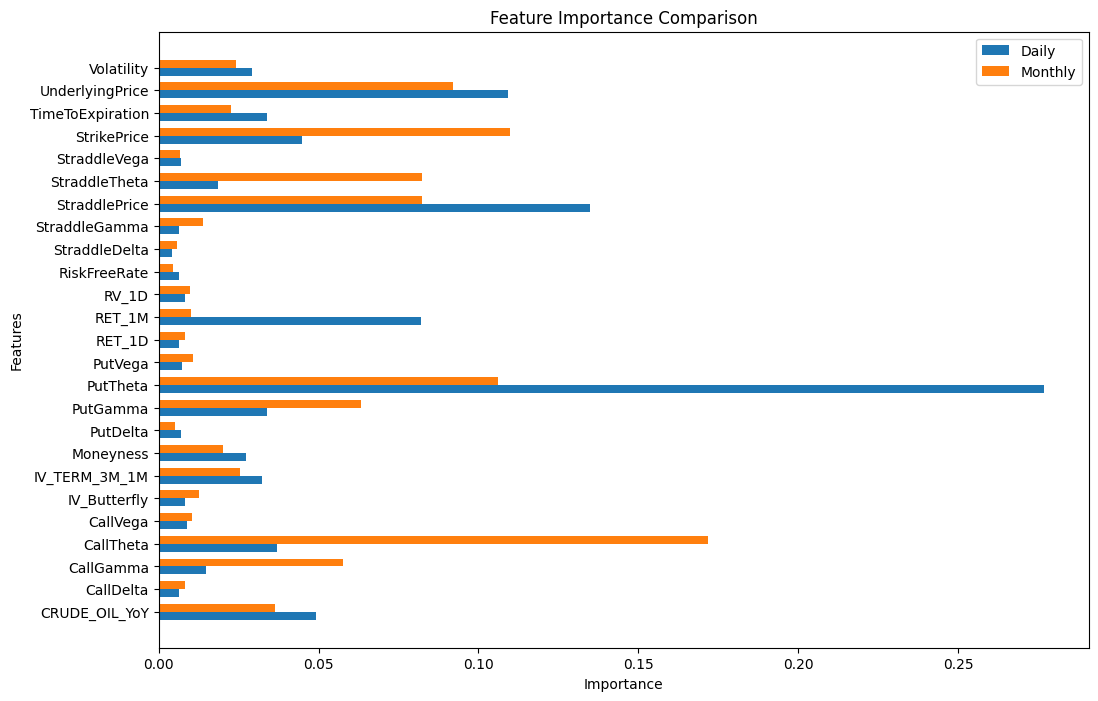

In [ ]:
feature_names_day = training_set_day.drop(columns=['Phi']).columns.tolist()
feature_importance_day = get_feature_importance(rf_daily, feature_names_day)

feature_names_month = training_set_month.drop(columns=['Phi']).columns.tolist()
feature_importance_month = get_feature_importance(rf_monthly, feature_names_month)

# Combine feature importance data
combined_feature_importance = pd.DataFrame({
    'Feature': feature_importance_day['Feature'],
    'Importance_Daily': feature_importance_day['Importance'],
    'Importance_Monthly': feature_importance_month['Importance']
})

# Sort by feature name alphabetically
combined_feature_importance.sort_values(by='Feature', inplace=True)

# Plot the feature importance
plt.figure(figsize=(12, 8))
bar_width = 0.35
index = np.arange(len(combined_feature_importance))

plt.barh(index, combined_feature_importance['Importance_Daily'], bar_width, label='Daily')
plt.barh(index + bar_width, combined_feature_importance['Importance_Monthly'], bar_width, label='Monthly')

plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importance Comparison')
plt.yticks(index + bar_width / 2, combined_feature_importance['Feature'])
plt.legend()
plt.show()

### Apply hedging strategy to both

In [29]:
print("Applying hedging model...")
results_df_daily = apply_hedging_model(
    first_straddles_monthly_test, 
    data_test, 
    real_market_df, 
    rf_daily, 
    transaction_cost=0.005
)

results_df_daily['Cumulative P&L'] = results_df_daily['P&L'].cumsum()
results_df_daily.set_index('StartDate', inplace=True)

results_df_daily

Applying hedging model...


,ExpirationDate,Initial Proceeds,Final Portfolio Value,Straddle Payoff,Hedging Error,P&L,Total Transaction Costs,Cumulative P&L
StartDate,,,,,,,,
2016-01-06,2016-02-05,83.50,83.542072,109.949951,697.376088,-26.407879,0.814645,-26.407879
2016-02-04,2016-03-11,95.00,93.575511,107.189941,185.352728,-13.614431,0.652247,-40.022310
2016-03-10,2016-04-15,79.65,78.680150,90.729980,145.198403,-12.049830,0.583773,-52.072140
2016-04-05,2016-05-13,72.95,72.981619,1.609985,5093.910139,71.371634,0.184650,19.299494
2016-05-04,2016-06-03,66.45,65.872641,49.129883,280.319936,16.742758,0.221773,36.042252
...,...,...,...,...,...,...,...,...
2023-04-06,2023-05-12,173.75,173.335590,19.080078,23794.762993,154.255512,1.238489,210.462513
2023-05-08,2023-06-09,141.80,139.759188,158.859863,364.835798,-19.100675,0.886249,191.361837
2023-06-08,2023-07-10,108.60,106.535629,114.529785,63.906533,-7.994156,1.388695,183.367681


In [30]:
print("Applying hedging model...")
results_df_monthly = apply_hedging_model(
    first_straddles_monthly_test, 
    data_test, 
    real_market_df, 
    rf_monthly, 
    transaction_cost=0.005
)

results_df_monthly['Cumulative P&L'] = results_df_monthly['P&L'].cumsum()
results_df_monthly.set_index('StartDate', inplace=True)

results_df_monthly

Applying hedging model...


,ExpirationDate,Initial Proceeds,Final Portfolio Value,Straddle Payoff,Hedging Error,P&L,Total Transaction Costs,Cumulative P&L
StartDate,,,,,,,,
2016-01-06,2016-02-05,83.50,83.866178,109.949951,680.363210,-26.083773,0.847381,-26.083773
2016-02-04,2016-03-11,95.00,93.916724,107.189941,176.178301,-13.273217,0.454704,-39.356990
2016-03-10,2016-04-15,79.65,78.867208,90.729980,140.725364,-11.862772,0.498028,-51.219763
2016-04-05,2016-05-13,72.95,72.768129,1.609985,5063.481453,71.158144,0.255182,19.938381
2016-05-04,2016-06-03,66.45,65.972314,49.129883,283.667498,16.842431,0.189004,36.780813
...,...,...,...,...,...,...,...,...
2023-04-06,2023-05-12,173.75,174.405946,19.080078,24126.125213,155.325868,0.398701,234.741042
2023-05-08,2023-06-09,141.80,141.313284,158.859863,307.882438,-17.546579,0.450552,217.194463
2023-06-08,2023-07-10,108.60,107.837223,114.529785,44.790390,-6.692562,0.922899,210.501901


### Compare both P&Ls

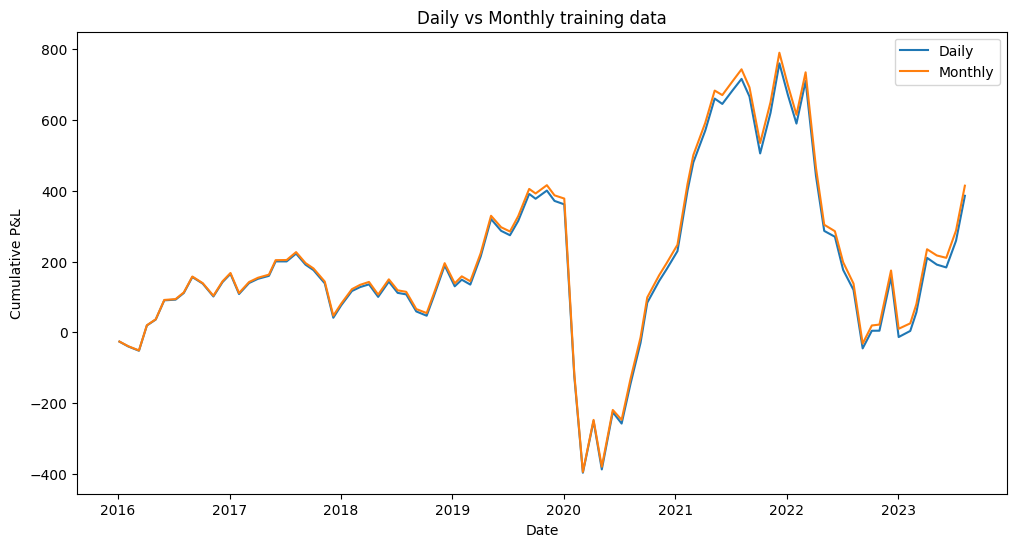

In [31]:
# Plot the cumulative P&L of the test data
plt.figure(figsize=(12, 6))
plt.plot(results_df_daily['Cumulative P&L'], label='Daily')
plt.plot(results_df_monthly['Cumulative P&L'], label='Monthly')
plt.title('Daily vs Monthly training data')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L')
plt.legend()
plt.show()

### Several plots to compare the three strategies

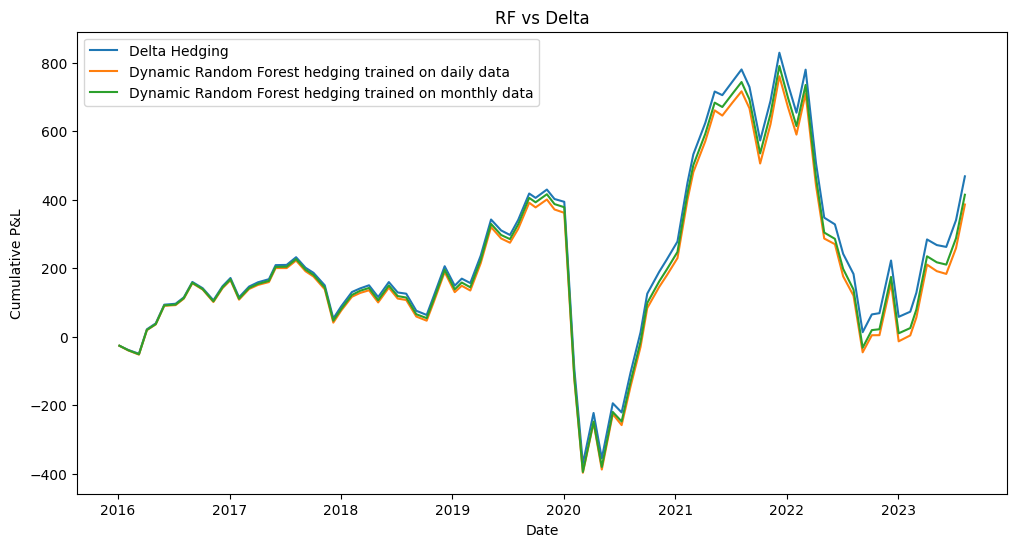

In [32]:
# Plot the cumulative P&L of the test data
plt.figure(figsize=(12, 6))
plt.plot(profit_no_cost_test['Cumulative P&L'], label='Delta Hedging')
plt.plot(results_df_daily['Cumulative P&L'], label='Dynamic Random Forest hedging trained on daily data')
plt.plot(results_df_monthly['Cumulative P&L'], label='Dynamic Random Forest hedging trained on monthly data')
plt.title('RF vs Delta')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L')
plt.legend()
plt.show()

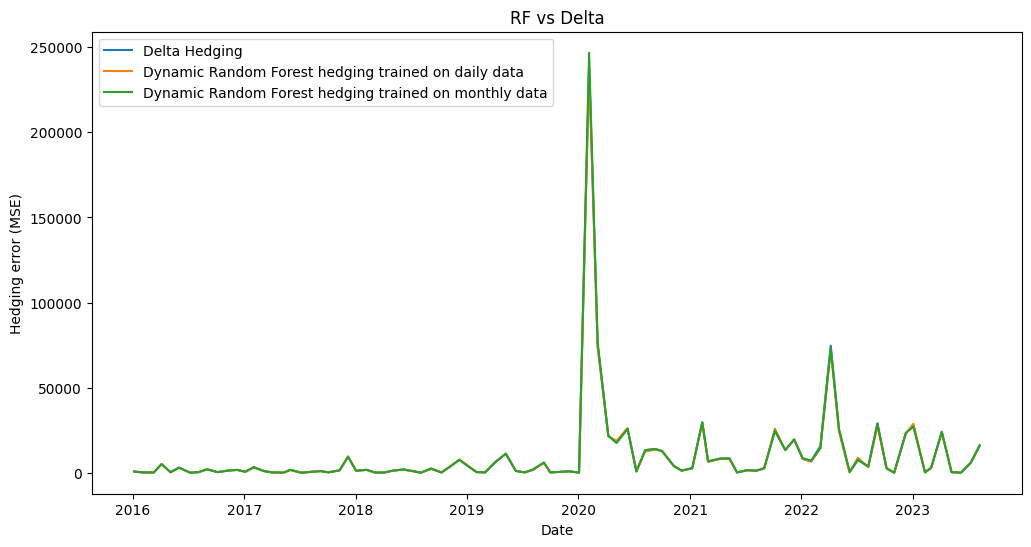

In [33]:
# Plot the hedging errors
plt.figure(figsize=(12, 6))
plt.plot(profit_cost_test['Hedging Error'], label='Delta Hedging')
plt.plot(results_df_daily['Hedging Error'], label='Dynamic Random Forest hedging trained on daily data')
plt.plot(results_df_monthly['Hedging Error'], label='Dynamic Random Forest hedging trained on monthly data')
plt.title('RF vs Delta')
plt.xlabel('Date')
plt.ylabel('Hedging error (MSE)')
plt.legend()
plt.show()

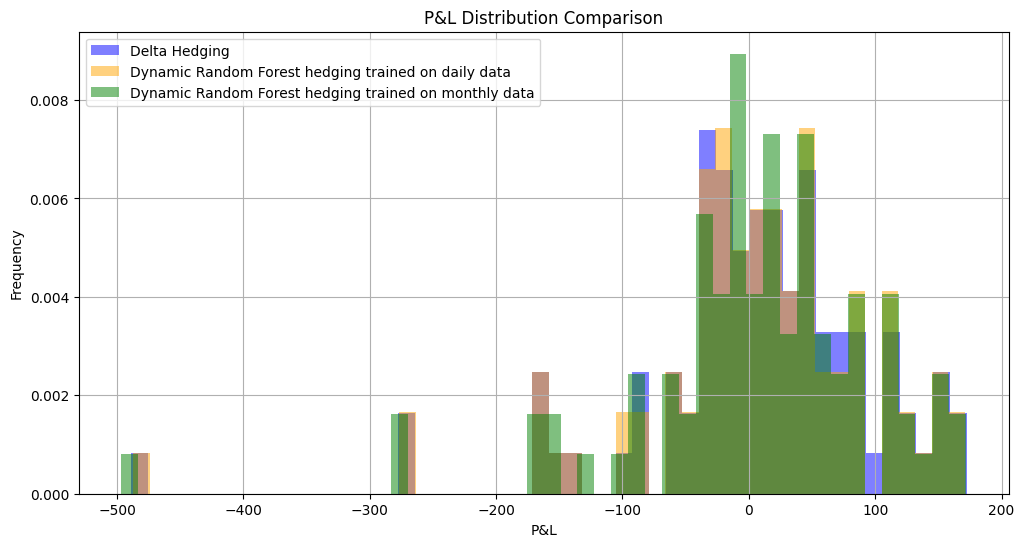

In [34]:
# Plot histograms for P&L distributions
plt.figure(figsize=(12, 6))

# Histogram for delta hedging model
plt.hist(profit_cost_test['P&L'], bins=50, alpha=0.5, label='Delta Hedging', color='blue', density=True)

# Histogram for the other model
plt.hist(results_df_daily['P&L'], bins=50, alpha=0.5, label='Dynamic Random Forest hedging trained on daily data', color='orange', density=True)

# Histogram for the other model
plt.hist(results_df_monthly['P&L'], bins=50, alpha=0.5, label='Dynamic Random Forest hedging trained on monthly data', color='green', density=True)

# Add titles and labels
plt.title('P&L Distribution Comparison')
plt.xlabel('P&L')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Moments

In [35]:
# Calculate statistical measures for delta hedging model
mean_delta_hedging = profit_cost_test['P&L'].mean()
median_delta_hedging = profit_cost_test['P&L'].median()
std_delta_hedging = profit_cost_test['P&L'].std()
skewness_delta_hedging = skew(profit_cost_test['P&L'])
kurtosis_delta_hedging = kurtosis(profit_cost_test['P&L'])

# Calculate statistical measures for the other model
mean_other_model_daily = results_df_daily['P&L'].mean()
median_other_model_daily = results_df_daily['P&L'].median()
std_other_model_daily = results_df_daily['P&L'].std()
skewness_other_model_daily = skew(results_df_daily['P&L'])
kurtosis_other_model_daily = kurtosis(results_df_daily['P&L'])

# Calculate statistical measures for the other model
mean_other_model_monthly = results_df_monthly['P&L'].mean()
median_other_model_monthly = results_df_monthly['P&L'].median()
std_other_model_monthly = results_df_monthly['P&L'].std()
skewness_other_model_monthly = skew(results_df_monthly['P&L'])
kurtosis_other_model_monthly = kurtosis(results_df_monthly['P&L'])

# Print the results
print("Delta Hedging Model:")
print(f"Mean: {mean_delta_hedging}")
print(f"Median: {median_delta_hedging}")
print(f"Standard Deviation: {std_delta_hedging}")
print(f"Skewness: {skewness_delta_hedging}")
print(f"Kurtosis: {kurtosis_delta_hedging}")

print("\nDynamic RF trained on daily data:")
print(f"Mean : {mean_other_model_daily}")
print(f"Median : {median_other_model_daily}")
print(f"Standard Deviation : {std_other_model_daily}")
print(f"Skewness : {skewness_other_model_daily}")
print(f"Kurtosis : {kurtosis_other_model_daily}")

print("\nDynamic RF trained on monthly data:")
print(f"Mean : {mean_other_model_monthly}")
print(f"Median : {median_other_model_monthly}")
print(f"Standard Deviation : {std_other_model_monthly}")
print(f"Skewness : {skewness_other_model_monthly}")
print(f"Kurtosis : {kurtosis_other_model_monthly}")

Delta Hedging Model:
Mean: 4.6233622566606165
Median: 11.131225870380202
Standard Deviation: 99.62706000252963
Skewness: -1.7285171947584541
Kurtosis: 6.0192037882497935

Dynamic RF trained on daily data:
Mean : 4.193894028655325
Median : 11.495324381238518
Standard Deviation : 99.08344151965188
Skewness : -1.7159873062842768
Kurtosis : 6.009322979190193

Dynamic RF trained on monthly data:
Mean : 4.504519806586133
Median : 12.116774543878424
Standard Deviation : 99.90482351486
Skewness : -1.769021328758156
Kurtosis : 6.316075661992846


In [36]:
### HIGHER KURTOSIS = FATTER TAILS (EVEN THOUGH MARGINAL)
### MORE NEGATIVE SKEWNESS = LONGER LEFT TAIL -> HIGHER FREQUENCY OF NEGATIVE RETURNS